In [ ]:
# Install required libraries
!pip install requests tqdm

import os
import requests
import json
import gzip
from datetime import datetime, timedelta
from google.colab import drive
from tqdm import tqdm
from calendar import monthrange

# Mount Google Drive
drive.mount('/content/drive')

SUBREDDIT = "Colombia"

# Set up directories
BASE_DIR = f"/content/drive/My Drive/Mining Sentiment Analysis/{SUBREDDIT}"
RAW_DATA_DIR = f"{BASE_DIR}/Raw Data"
os.makedirs(RAW_DATA_DIR, exist_ok=True)

class ArcticShiftClient:
    BASE_URL = "https://arctic-shift.photon-reddit.com/api"

    def __init__(self):
        self.session = requests.Session()

    def search_comments(self, **params):
        response = self.session.get(f"{self.BASE_URL}/comments/search", params=params)
        response.raise_for_status()
        return response.json()

class CommentDownloader:
    def __init__(self, subreddit: str, start_date: str, end_date: str, output_dir: str):
        self.client = ArcticShiftClient()
        self.subreddit = subreddit
        self.start_date = self._parse_date(start_date)
        self.end_date = self._parse_date(end_date)
        self.output_dir = output_dir
        self.checkpoint_dir = os.path.join(output_dir, "checkpoints")
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    def _parse_date(self, date_string: str) -> datetime:
        return datetime.strptime(date_string, "%Y-%m-%d")

    def download_comments(self):
        current_date = self.start_date.replace(day=1)
        while current_date <= self.end_date:
            self._download_comments_for_month(current_date)
            current_date = (current_date.replace(day=28) + timedelta(days=4)).replace(day=1)

    def _download_comments_for_month(self, start_of_month: datetime):
        year, month = start_of_month.year, start_of_month.month
        _, last_day = monthrange(year, month)
        end_of_month = start_of_month.replace(day=last_day)

        checkpoint_file = os.path.join(self.checkpoint_dir, f"{year}_{month:02d}.json")

        if os.path.exists(checkpoint_file):
            with open(checkpoint_file, "r") as f:
                checkpoint = json.load(f)
        else:
            checkpoint = {"last_created_utc": None}

        comments = []
        current_date = start_of_month
        while current_date <= end_of_month:
            while True:
                batch = self._get_comment_batch(current_date, checkpoint["last_created_utc"])
                if not batch:
                    break
                comments.extend(batch)
                checkpoint["last_created_utc"] = batch[-1]["created_utc"]
                self._save_checkpoint(checkpoint_file, checkpoint)

            current_date += timedelta(days=1)

        if comments:
            self._save_comments(year, month, comments)

    def _get_comment_batch(self, date: datetime, after_utc: int = None):
        params = {
            "subreddit": self.subreddit,
            "after": date.isoformat(),
            "before": (date + timedelta(days=1)).isoformat(),
            "sort": "asc",
            "limit": 100,
        }
        if after_utc:
            params["after"] = datetime.utcfromtimestamp(after_utc).isoformat()

        response = self.client.search_comments(**params)
        return response.get("data", [])

    def _save_checkpoint(self, checkpoint_file: str, checkpoint: dict):
        with open(checkpoint_file, "w") as f:
            json.dump(checkpoint, f)

    def _save_comments(self, year: int, month: int, comments):
        output_file = os.path.join(self.output_dir, f"{self.subreddit}_comments_{year}_{month:02d}.json.gz")
        with gzip.open(output_file, "wt", encoding="utf-8") as f:
            json.dump(comments, f)
        print(f"Saved {len(comments)} comments for {year}-{month:02d}")

start_date = "2019-01-01"
end_date = "2024-05-31"

# Download comments
downloader = CommentDownloader(SUBREDDIT, start_date, end_date, RAW_DATA_DIR)
downloader.download_comments()

print("Comment download complete.")

Mounted at /content/drive
Saved 3653 comments for 2019-01
Saved 3765 comments for 2019-02
Saved 2439 comments for 2019-03
Saved 2431 comments for 2019-04
Saved 2065 comments for 2019-05
Saved 2176 comments for 2019-06
Saved 1926 comments for 2019-07
Saved 2059 comments for 2019-08
Saved 1837 comments for 2019-09
Saved 2345 comments for 2019-10
Saved 3639 comments for 2019-11
Saved 2801 comments for 2019-12
Saved 3183 comments for 2020-01
Saved 3225 comments for 2020-02
Saved 3540 comments for 2020-03
Saved 3444 comments for 2020-04
Saved 3615 comments for 2020-05
Saved 3497 comments for 2020-06
Saved 3051 comments for 2020-07
Saved 4378 comments for 2020-08
Saved 5376 comments for 2020-09
Saved 4179 comments for 2020-10
Saved 4531 comments for 2020-11
Saved 4765 comments for 2020-12
Saved 6027 comments for 2021-01
Saved 5421 comments for 2021-02
Saved 4628 comments for 2021-03
Saved 6994 comments for 2021-04
Saved 15957 comments for 2021-05
Saved 6179 comments for 2021-06
Saved 8257 co

In [1]:
import os
import json
import gzip
import re
from google.colab import drive
from tqdm.notebook import tqdm
from collections import Counter

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

SUBREDDIT = "Colombia"

# Set up directories
BASE_DIR = f"/content/drive/My Drive/Mining Sentiment Analysis/{SUBREDDIT}"
RAW_DATA_DIR = f"{BASE_DIR}/Raw Data"
FILTERED_DATA_DIR = f"{BASE_DIR}/Filtered Data"
os.makedirs(FILTERED_DATA_DIR, exist_ok=True)

def create_mining_lexicon():
    return {
        'high_relevance_keywords': [
            'Cerrejón', 'La Colosa', 'AngloGold Ashanti', 'Drummond',
            'Mineros S.A.', 'Gran Colombia Gold', 'Continental Gold',
            'mina de carbón', 'mina de oro', 'extracción de carbón',
            'proyecto minero Colombia', 'impacto ambiental minería Colombia',
            'protesta minera Colombia', 'ley minera Colombia', 'contrato minero Colombia'
        ],
        'medium_relevance_keywords': [
            'minería', 'mina', 'excavación', 'extracción', 'yacimiento',
            'carbón', 'oro', 'níquel', 'esmeraldas', 'coltán',
            'impacto ambiental', 'contaminación minera', 'deforestación',
            'economía minera', 'empleo minero', 'desarrollo minero',
            'inversión minera', 'conflicto minero', 'regulación minera',
            'minería ilegal', 'minería artesanal', 'consulta previa'
        ],
        'low_relevance_keywords': [
            'mineral', 'recursos naturales', 'metales preciosos',
            'industria extractiva', 'sostenibilidad',
            'licencia ambiental', 'Agencia Nacional de Minería',
            'regalías mineras', 'zonas mineras'
        ],
        'negative_keywords': [
            'minecraft', 'juego', 'videojuego',
            'data mining', 'minería de datos'
        ],
        'context_phrases': [
            r'(mina|minería|extracción)\s+.*\s+(carbón|oro|níquel|esmeraldas)',
            r'(protesta|conflicto)\s+.*\s+(mina|minería|Cerrejón|La Colosa)',
            r'(impacto|efecto)\s+.*\s+(mina|minería|Cerrejón|La Colosa)',
            r'(ley|regulación|contrato)\s+.*\s+(mina|minería|Colombia)',
            r'(comunidad|indígena)\s+.*\s+(mina|minería|consulta previa)'
        ]
    }

def calculate_relevance_score(text, lexicon):
    text = text.lower()
    score = 0

    # Check for negative keywords first
    if any(keyword in text for keyword in lexicon['negative_keywords']):
        return 0

    # Check for high relevance keywords
    for keyword in lexicon['high_relevance_keywords']:
        if keyword.lower() in text:
            score += 3

    # Check for medium relevance keywords
    for keyword in lexicon['medium_relevance_keywords']:
        if keyword.lower() in text:
            score += 2

    # Check for low relevance keywords
    for keyword in lexicon['low_relevance_keywords']:
        if keyword.lower() in text:
            score += 1

    # Check for context phrases
    for phrase in lexicon['context_phrases']:
        if re.search(phrase, text):
            score += 2

    return score

def is_relevant_comment(text, lexicon, threshold=3):
    score = calculate_relevance_score(text, lexicon)
    return score >= threshold

def filter_file(input_file, output_file, lexicon):
    with gzip.open(input_file, 'rt', encoding='utf-8') as f:
        comments = json.load(f)

    relevant_comments = [comment for comment in comments if is_relevant_comment(comment['body'], lexicon)]

    if relevant_comments:
        with gzip.open(output_file, 'wt', encoding='utf-8') as f:
            json.dump(relevant_comments, f)

        print(f"Filtered {len(relevant_comments)} comments from {os.path.basename(input_file)}")
    else:
        print(f"No relevant comments found in {os.path.basename(input_file)}")

    return relevant_comments

def analyze_keywords(comments, lexicon):
    keyword_counter = Counter()
    for comment in comments:
        text = comment['body'].lower()
        for keyword_list in lexicon.values():
            for keyword in keyword_list:
                if isinstance(keyword, str) and keyword.lower() in text:
                    keyword_counter[keyword] += 1
    return keyword_counter

# Create lexicon for filtering
lexicon = create_mining_lexicon()

# Filter all files in the Raw Data directory
files = [f for f in os.listdir(RAW_DATA_DIR) if f.startswith(f"{SUBREDDIT}_comments_") and f.endswith(".json.gz")]

all_relevant_comments = []

for filename in tqdm(files, desc="Filtering files", unit="file"):
    input_file = os.path.join(RAW_DATA_DIR, filename)
    output_file = os.path.join(FILTERED_DATA_DIR, f"filtered_{filename}")
    relevant_comments = filter_file(input_file, output_file, lexicon)
    all_relevant_comments.extend(relevant_comments)

print("Filtering complete.")

# Analyze keywords in relevant comments
keyword_analysis = analyze_keywords(all_relevant_comments, lexicon)

print("\nTop 20 most common keywords in relevant comments:")
for keyword, count in keyword_analysis.most_common(20):
    print(f"{keyword}: {count}")

Mounted at /content/drive


Filtering files:   0%|          | 0/65 [00:00<?, ?file/s]

Filtered 85 comments from Colombia_comments_2023_01.json.gz
Filtered 54 comments from Colombia_comments_2023_02.json.gz
Filtered 1 comments from Colombia_comments_2019_01.json.gz
Filtered 4 comments from Colombia_comments_2019_02.json.gz
Filtered 1 comments from Colombia_comments_2019_03.json.gz
Filtered 5 comments from Colombia_comments_2019_04.json.gz
Filtered 7 comments from Colombia_comments_2019_05.json.gz
Filtered 2 comments from Colombia_comments_2019_06.json.gz
Filtered 2 comments from Colombia_comments_2019_07.json.gz
Filtered 2 comments from Colombia_comments_2019_08.json.gz
Filtered 1 comments from Colombia_comments_2019_09.json.gz
Filtered 1 comments from Colombia_comments_2019_10.json.gz
Filtered 1 comments from Colombia_comments_2019_11.json.gz
No relevant comments found in Colombia_comments_2019_12.json.gz
Filtered 2 comments from Colombia_comments_2020_01.json.gz
Filtered 2 comments from Colombia_comments_2020_02.json.gz
Filtered 6 comments from Colombia_comments_2020_0

In [11]:
import os
import json
import gzip
import csv
from datetime import datetime
from collections import defaultdict
import re
from google.colab import drive
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from statistics import mean, median, stdev

nltk.download('punkt')
nltk.download('stopwords')

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

SUBREDDIT = "Colombia"

# Set up directories
BASE_DIR = f"/content/drive/My Drive/Mining Sentiment Analysis/{SUBREDDIT}"
FILTERED_DATA_DIR = f"{BASE_DIR}/Filtered Data"
STATS_DIR = f"{BASE_DIR}/Stats"
os.makedirs(STATS_DIR, exist_ok=True)

def create_mining_lexicon():
    return {
        'positive': {
            'creación de empleo': 2,
            'crecimiento económico': 2,
            'desarrollo': 1,
            'inversión': 1,
            'tecnología': 1,
            'minería responsable': 3,
            'sostenible': 2,
            'apoyo comunitario': 2,
            'protección ambiental': 2,
            'medidas de seguridad': 2,
            'beneficios locales': 2,
            'ingresos fiscales': 2,
            'mejora de infraestructura': 2,
            'progreso': 1,
            'innovación': 2,
            'empleo': 2,
            'oportunidades': 2,
            'desarrollo social': 2,
            'responsabilidad social': 2,
            'restauración ecológica': 3,
            'energía limpia': 2,
            'minería verde': 3,
            'tecnología limpia': 2,
            'eficiencia energética': 2,
            'reciclaje': 1,
            'economía circular': 2,
            'biodiversidad': 2,
            'conservación': 2,
            'rehabilitación': 2,
            'transparencia': 2,
            'diálogo': 1,
            'participación ciudadana': 2,
            'beneficio mutuo': 2,
            'desarrollo sostenible': 3,
            'educación': 1,
            'capacitación': 1,
            'seguridad laboral': 2
        },
        'negative': {
            'daño ambiental': -2,
            'contaminación': -2,
            'deforestación': -2,
            'contaminación del agua': -3,
            'riesgos de salud': -3,
            'explotación': -2,
            'corrupción': -3,
            'injusto': -1,
            'dañino': -2,
            'protesta': -1,
            'destrucción': -2,
            'desplazamiento': -2,
            'conflicto': -2,
            'controversia': -1,
            'erosión': -2,
            'degradación del suelo': -2,
            'pérdida de biodiversidad': -3,
            'contaminación del aire': -3,
            'agotamiento de recursos': -2,
            'cambio climático': -2,
            'gases de efecto invernadero': -2,
            'desechos tóxicos': -3,
            'metales pesados': -2,
            'drenaje ácido': -3,
            'derrames': -2,
            'accidentes': -2,
            'ruido': -1,
            'polvo': -1,
            'vibraciones': -1,
            'impacto visual': -1,
            'desplazamiento de comunidades': -3,
            'pérdida de tierras': -2,
            'violación de derechos': -3,
            'trabajo infantil': -3,
            'condiciones laborales peligrosas': -3,
            'explotación laboral': -2,
            'falta de transparencia': -2,
            'evasión fiscal': -3,
            'soborno': -3,
            'conflictos sociales': -2,
            'militarización': -2,
            'violencia': -3,
            'intimidación': -2,
            'represión': -3
        },
        'neutral': {
            'regulación': 0,
            'política': 0,
            'acuerdo': 0,
            'discusión': 0,
            'negociación': 0,
            'evaluación de impacto': 0,
            'consulta comunitaria': 0,
            'participación de las partes interesadas': 0,
            'legislación minera': 0,
            'código minero': 0,
            'concesiones mineras': 0,
            'exploración': 0,
            'extracción': 0,
            'procesamiento': 0,
            'cierre de minas': 0,
            'rehabilitación de minas': 0,
            'monitoreo ambiental': 0,
            'estudio de impacto ambiental': 0,
            'plan de manejo ambiental': 0,
            'licencia social': 0,
            'consulta previa': 0,
            'audiencia pública': 0,
            'resolución de conflictos': 0,
            'mediación': 0,
            'arbitraje': 0,
            'responsabilidad empresarial': 0,
            'gobernanza': 0,
            'cadena de suministro': 0,
            'trazabilidad': 0,
            'certificación': 0,
            'estándares internacionales': 0,
            'derechos indígenas': 0,
            'derechos humanos': 0,
            'sindicalización': 0,
            'royalties': 0,
            'impuestos': 0,
            'distribución de beneficios': 0
        }
    }

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('spanish'))
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

def calculate_mining_sentiment(text, lexicon, upvotes):
    text = preprocess_text(text)
    score = 0
    word_count = len(text.split())

    for category in lexicon:
        for phrase, value in lexicon[category].items():
            if phrase in text:
                score += value

    if re.search(r'(opon|contra|detener)\s+.*\s+miner(í|i)a', text):
        score -= 3
    if re.search(r'(apoya|a favor de|pro)\s+.*\s+miner(í|i)a', text):
        score += 3

    # Apply upvote weighting
    upvote_weight = 1 + (upvotes / 1)  # Adjust the divisor to control the impact of upvotes
    weighted_score = score * upvote_weight

    normalized_score = weighted_score / (word_count + 1)

    return normalized_score

lexicon = create_mining_lexicon()
daily_stats = defaultdict(lambda: {
    'sentiments': [],
    'comment_count': 0,
    'unique_users': set(),
    'word_counts': [],
    'scores': [],
    'upvotes': [],
    'user_sentiments': defaultdict(list)
})

total_comments = 0
unique_users_total = set()

for filename in os.listdir(FILTERED_DATA_DIR):
    if filename.startswith(f"filtered_{SUBREDDIT}_comments_") and filename.endswith(".json.gz"):
        with gzip.open(os.path.join(FILTERED_DATA_DIR, filename), 'rt', encoding='utf-8') as f:
            comments = json.load(f)
            for comment in comments:
                date = datetime.utcfromtimestamp(comment['created_utc']).strftime('%Y-%m-%d')
                sentiment = calculate_mining_sentiment(comment['body'], lexicon, comment['ups'])

                daily_stats[date]['sentiments'].append(sentiment)
                daily_stats[date]['comment_count'] += 1
                daily_stats[date]['unique_users'].add(comment['author'])
                daily_stats[date]['word_counts'].append(len(comment['body'].split()))
                daily_stats[date]['scores'].append(comment['score'])
                daily_stats[date]['upvotes'].append(comment['ups'])
                daily_stats[date]['user_sentiments'][comment['author']].append(sentiment)

                total_comments += 1
                unique_users_total.add(comment['author'])

# Calculate statistics
overall_stats = {
    'total_comments': total_comments,
    'total_unique_users': len(unique_users_total),
    'user_participation_ratio': len(unique_users_total) / total_comments if total_comments > 0 else 0
}

def calculate_user_weighted_sentiment(user_sentiments):
    if not user_sentiments:
        return 0
    user_avg_sentiments = [mean(sentiments) for sentiments in user_sentiments.values()]
    return mean(user_avg_sentiments)

def calculate_frequency_adjusted_sentiment(sentiments, unique_user_count):
    if not sentiments or unique_user_count == 0:
        return 0
    adjustment_factor = unique_user_count / len(sentiments)
    return mean(sentiments) * adjustment_factor

# Write to CSV
output_file = os.path.join(STATS_DIR, f'{SUBREDDIT}_daily_stats.csv')
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        'Date', 'Average Sentiment', 'User-Weighted Sentiment', 'Frequency-Adjusted Sentiment',
        'Comment Count', 'Unique Users', 'User Participation Ratio',
        'Avg Word Count', 'Median Word Count', 'Avg Score', 'Median Score',
        'Avg Upvotes', 'Median Upvotes', 'Sentiment StdDev', 'Word Count StdDev',
        'Score StdDev', 'Upvotes StdDev'
    ])

    for date in sorted(daily_stats.keys()):
        stats = daily_stats[date]
        writer.writerow([
            date,
            mean(stats['sentiments']),
            calculate_user_weighted_sentiment(stats['user_sentiments']),
            calculate_frequency_adjusted_sentiment(stats['sentiments'], len(stats['unique_users'])),
            stats['comment_count'],
            len(stats['unique_users']),
            len(stats['unique_users']) / stats['comment_count'] if stats['comment_count'] > 0 else 0,
            mean(stats['word_counts']),
            median(stats['word_counts']),
            mean(stats['scores']),
            median(stats['scores']),
            mean(stats['upvotes']),
            median(stats['upvotes']),
            stdev(stats['sentiments']) if len(stats['sentiments']) > 1 else 0,
            stdev(stats['word_counts']) if len(stats['word_counts']) > 1 else 0,
            stdev(stats['scores']) if len(stats['scores']) > 1 else 0,
            stdev(stats['upvotes']) if len(stats['upvotes']) > 1 else 0
        ])

# Write overall statistics to a separate CSV
overall_stats_file = os.path.join(STATS_DIR, f'{SUBREDDIT}_overall_stats.csv')
with open(overall_stats_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for key, value in overall_stats.items():
        writer.writerow([key, value])

print(f"Daily statistics CSV created: {output_file}")
print(f"Overall statistics CSV created: {overall_stats_file}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Daily statistics CSV created: /content/drive/My Drive/Mining Sentiment Analysis/Colombia/Stats/Colombia_daily_stats.csv
Overall statistics CSV created: /content/drive/My Drive/Mining Sentiment Analysis/Colombia/Stats/Colombia_overall_stats.csv


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


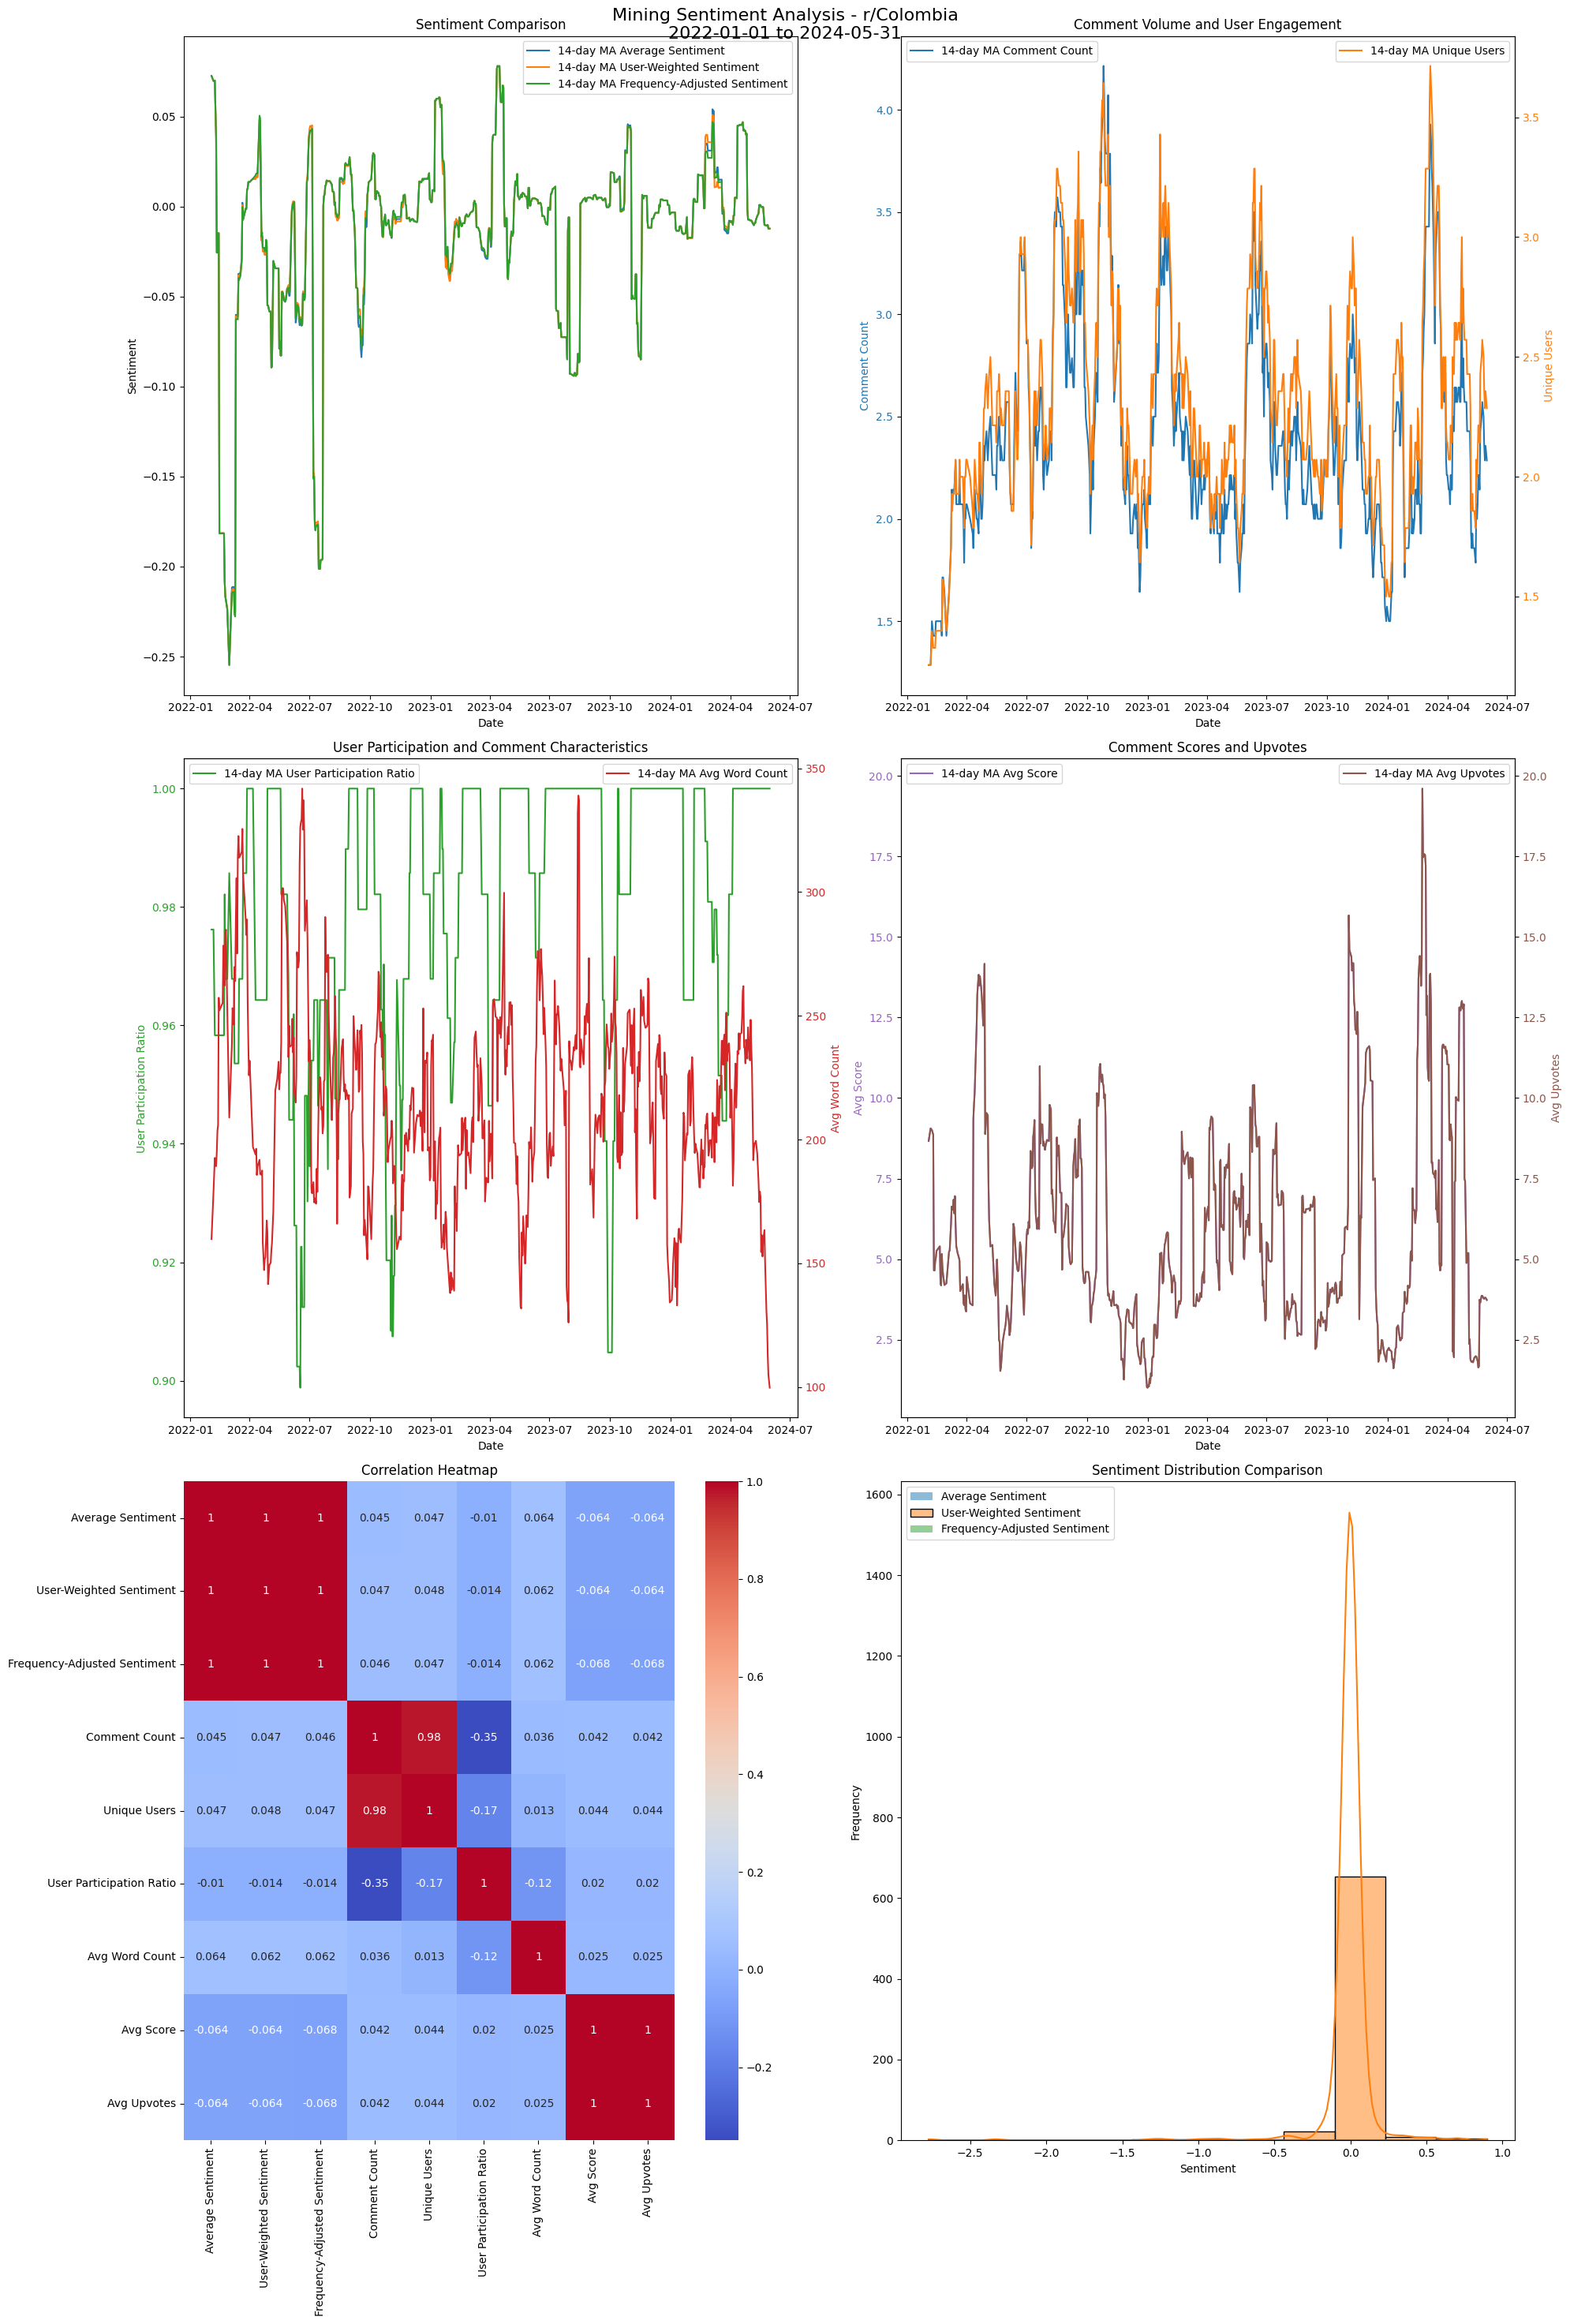

Visualization saved as: /content/drive/My Drive/Mining Sentiment Analysis/Colombia/Stats/Colombia_sentiment_analysis_2022-01-01_2024-05-31.png
Summary statistics saved as: /content/drive/My Drive/Mining Sentiment Analysis/Colombia/Stats/Colombia_summary_statistics_2022-01-01_2024-05-31.csv


<Figure size 640x480 with 0 Axes>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from datetime import datetime

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

SUBREDDIT = "Colombia"

# Set up directories
BASE_DIR = f"/content/drive/My Drive/Mining Sentiment Analysis/{SUBREDDIT}"
STATS_DIR = f"{BASE_DIR}/Stats"

START_DATE = '2022-01-01'
END_DATE = '2024-05-31'

# Read the CSV file
df = pd.read_csv(f"{STATS_DIR}/{SUBREDDIT}_daily_stats.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Filter data based on date range
df = df[(df['Date'] >= START_DATE) & (df['Date'] <= END_DATE)]

# Calculate moving averages
window_size = 14  # 7-day moving average
for column in ['Average Sentiment', 'User-Weighted Sentiment', 'Frequency-Adjusted Sentiment',
               'Comment Count', 'Unique Users', 'User Participation Ratio', 'Avg Word Count', 'Avg Score', 'Avg Upvotes']:
    df[f'MA_{column}'] = df[column].rolling(window=window_size).mean()

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 30))
fig.suptitle(f'Mining Sentiment Analysis - r/{SUBREDDIT}\n{START_DATE} to {END_DATE}', fontsize=16)

# 1. Sentiment Comparison
ax1 = axs[0, 0]
ax1.set_title('Sentiment Comparison')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment')
ax1.plot(df['Date'], df['MA_Average Sentiment'], label=f'{window_size}-day MA Average Sentiment')
ax1.plot(df['Date'], df['MA_User-Weighted Sentiment'], label=f'{window_size}-day MA User-Weighted Sentiment')
ax1.plot(df['Date'], df['MA_Frequency-Adjusted Sentiment'], label=f'{window_size}-day MA Frequency-Adjusted Sentiment')
ax1.legend(loc='best')

# 2. Comment Volume and User Engagement
ax2 = axs[0, 1]
ax2.set_title('Comment Volume and User Engagement')
ax2.set_xlabel('Date')
ax2.set_ylabel('Comment Count', color='tab:blue')
ax2.plot(df['Date'], df['MA_Comment Count'], color='tab:blue', label=f'{window_size}-day MA Comment Count')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper left')

ax3 = ax2.twinx()
ax3.set_ylabel('Unique Users', color='tab:orange')
ax3.plot(df['Date'], df['MA_Unique Users'], color='tab:orange', label=f'{window_size}-day MA Unique Users')
ax3.tick_params(axis='y', labelcolor='tab:orange')
ax3.legend(loc='upper right')

# 3. User Participation and Comment Characteristics
ax4 = axs[1, 0]
ax4.set_title('User Participation and Comment Characteristics')
ax4.set_xlabel('Date')
ax4.set_ylabel('User Participation Ratio', color='tab:green')
ax4.plot(df['Date'], df['MA_User Participation Ratio'], color='tab:green', label=f'{window_size}-day MA User Participation Ratio')
ax4.tick_params(axis='y', labelcolor='tab:green')
ax4.legend(loc='upper left')

ax5 = ax4.twinx()
ax5.set_ylabel('Avg Word Count', color='tab:red')
ax5.plot(df['Date'], df['MA_Avg Word Count'], color='tab:red', label=f'{window_size}-day MA Avg Word Count')
ax5.tick_params(axis='y', labelcolor='tab:red')
ax5.legend(loc='upper right')

# 4. Comment Scores and Upvotes
ax6 = axs[1, 1]
ax6.set_title('Comment Scores and Upvotes')
ax6.set_xlabel('Date')
ax6.set_ylabel('Avg Score', color='tab:purple')
ax6.plot(df['Date'], df['MA_Avg Score'], color='tab:purple', label=f'{window_size}-day MA Avg Score')
ax6.tick_params(axis='y', labelcolor='tab:purple')
ax6.legend(loc='upper left')

ax7 = ax6.twinx()
ax7.set_ylabel('Avg Upvotes', color='tab:brown')
ax7.plot(df['Date'], df['MA_Avg Upvotes'], color='tab:brown', label=f'{window_size}-day MA Avg Upvotes')
ax7.tick_params(axis='y', labelcolor='tab:brown')
ax7.legend(loc='upper right')

# 5. Correlation Heatmap
ax8 = axs[2, 0]
ax8.set_title('Correlation Heatmap')
corr_columns = ['Average Sentiment', 'User-Weighted Sentiment', 'Frequency-Adjusted Sentiment',
                'Comment Count', 'Unique Users', 'User Participation Ratio', 'Avg Word Count', 'Avg Score', 'Avg Upvotes']
corr_matrix = df[corr_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax8)

# 6. Sentiment Distribution Comparison
ax9 = axs[2, 1]
ax9.set_title('Sentiment Distribution Comparison')
sns.histplot(df['Average Sentiment'], kde=True, ax=ax9, label='Average Sentiment', alpha=0.5)
sns.histplot(df['User-Weighted Sentiment'], kde=True, ax=ax9, label='User-Weighted Sentiment', alpha=0.5)
sns.histplot(df['Frequency-Adjusted Sentiment'], kde=True, ax=ax9, label='Frequency-Adjusted Sentiment', alpha=0.5)
ax9.set_xlabel('Sentiment')
ax9.set_ylabel('Frequency')
ax9.legend()

plt.tight_layout()
plt.show()

# Save the plot
plot_file = f"{STATS_DIR}/{SUBREDDIT}_sentiment_analysis_{START_DATE}_{END_DATE}.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"Visualization saved as: {plot_file}")

# Generate summary statistics
summary_stats = df[['Average Sentiment', 'User-Weighted Sentiment', 'Frequency-Adjusted Sentiment',
                    'Comment Count', 'Unique Users', 'User Participation Ratio', 'Avg Word Count', 'Avg Score', 'Avg Upvotes']].describe()
summary_file = f"{STATS_DIR}/{SUBREDDIT}_summary_statistics_{START_DATE}_{END_DATE}.csv"
summary_stats.to_csv(summary_file)
print(f"Summary statistics saved as: {summary_file}")